In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
])

# Download and load CIFAR-10 dataset
batch_size = 64
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [4]:
import torch.nn as nn

class InvertibleConvLayer(nn.Module):
    def __init__(self, in_channels):
        super(InvertibleConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.log_det_jacobian = None  # For calculating log determinant of the Jacobian

    def forward(self, x):
        self.log_det_jacobian = torch.log(torch.abs(torch.det(self.conv.weight)))  # Compute the log determinant
        return self.conv(x)

    def inverse(self, y):
        # Inverse operation using torch.linalg.pinv for simplicity
        return nn.functional.conv2d(y, self.conv.weight.inverse(), stride=1, padding=1)

class ICN(nn.Module):
    def __init__(self, num_layers, in_channels):
        super(ICN, self).__init__()
        self.layers = nn.ModuleList([InvertibleConvLayer(in_channels) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def inverse(self, y):
        for layer in reversed(self.layers):
            y = layer.inverse(y)
        return y


In [5]:
import torch.optim as optim

# Instantiate model, optimizer, and loss function
model = ICN(num_layers=5, in_channels=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images
        
        optimizer.zero_grad()
        output = model(images)  # Forward pass
        loss = criterion(output, images)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.0330
Epoch [2/10], Loss: 0.0058
Epoch [3/10], Loss: 0.0017
Epoch [4/10], Loss: 0.0010
Epoch [5/10], Loss: 0.0007
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0003
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-29151494000.0..26347256000.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-24063734000.0..22997848000.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-26019640000.0..26710305000.0].


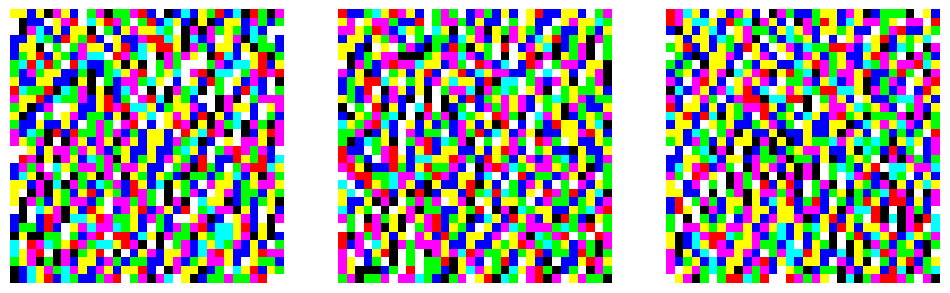

In [6]:
import matplotlib.pyplot as plt

def generate_images(model, num_samples):
    model.eval()
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, 3, 32, 32)  # Random latent samples
        generated_images = model.inverse(latent_samples)
    return generated_images.cpu()

# Generate and visualize images
num_samples = 3
generated_images = generate_images(model, num_samples)

# Plot the generated images
plt.figure(figsize=(12,6))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow((generated_images[i].permute(1, 2, 0) + 1) / 2)  # Denormalize
    plt.axis('off')
plt.show()
